<a href="https://colab.research.google.com/github/google/tunix/blob/main/examples/qlora_demo.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries

In [1]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
!pip install -q jax==0.6.2 jaxlib==0.6.2
# !pip install -q git+https://github.com/google/tunix
! pip install -q ~/tunix/
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git

!pip install -q tensorflow-datasets

!pip install -q git+https://github.com/AI-Hypercomputer/pathways-utils.git


In [2]:
# # If you want to upload your metrics to Weights & Biases, please install the package and login. Make sure to install `wandb` before importing `tunix`.
# !pip install wandb

# import wandb
# wandb.login()

If `wandb` is installed, you'll see a message like the one below when you start the experiment:

```
Tracking run with wandb version 0.21.0
Run data is saved locally in /content/wandb/run-20250717_224322-kmvoi0ho
Syncing run 2025-07-17_22-43-22 to Weights & Biases (docs)
View project at https://wandb.ai/<wandb_username>/tunix?apiKey=<api_key>
View run at https://wandb.ai/<wandb_username>/tunix/runs/kmvoi0ho?apiKey=<api_key>
Do NOT share these links with anyone. They can be used to claim your runs.
```

After clicking the link, you will be directed to the following Weights & Biases metrics page which contain train metrics, eval metrics, system metrics, and various custom metric you wish to report:

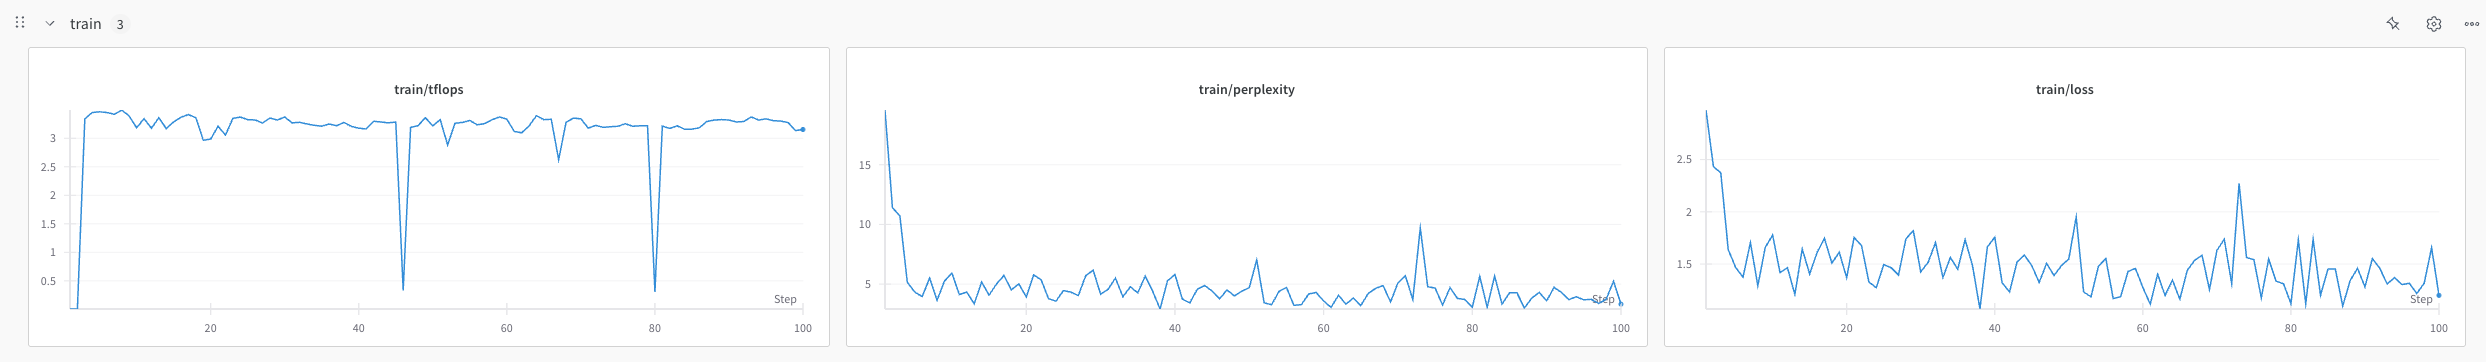

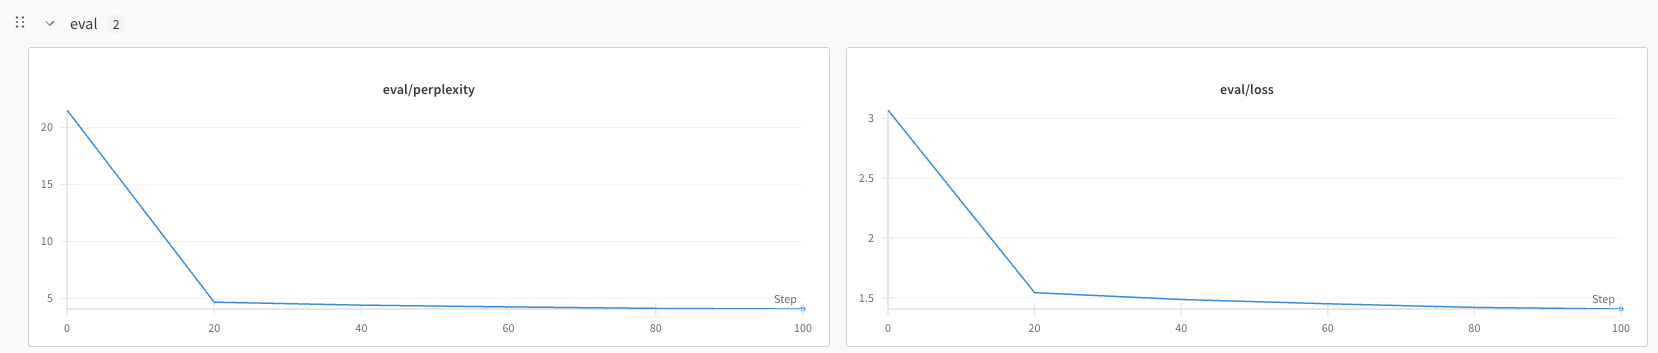

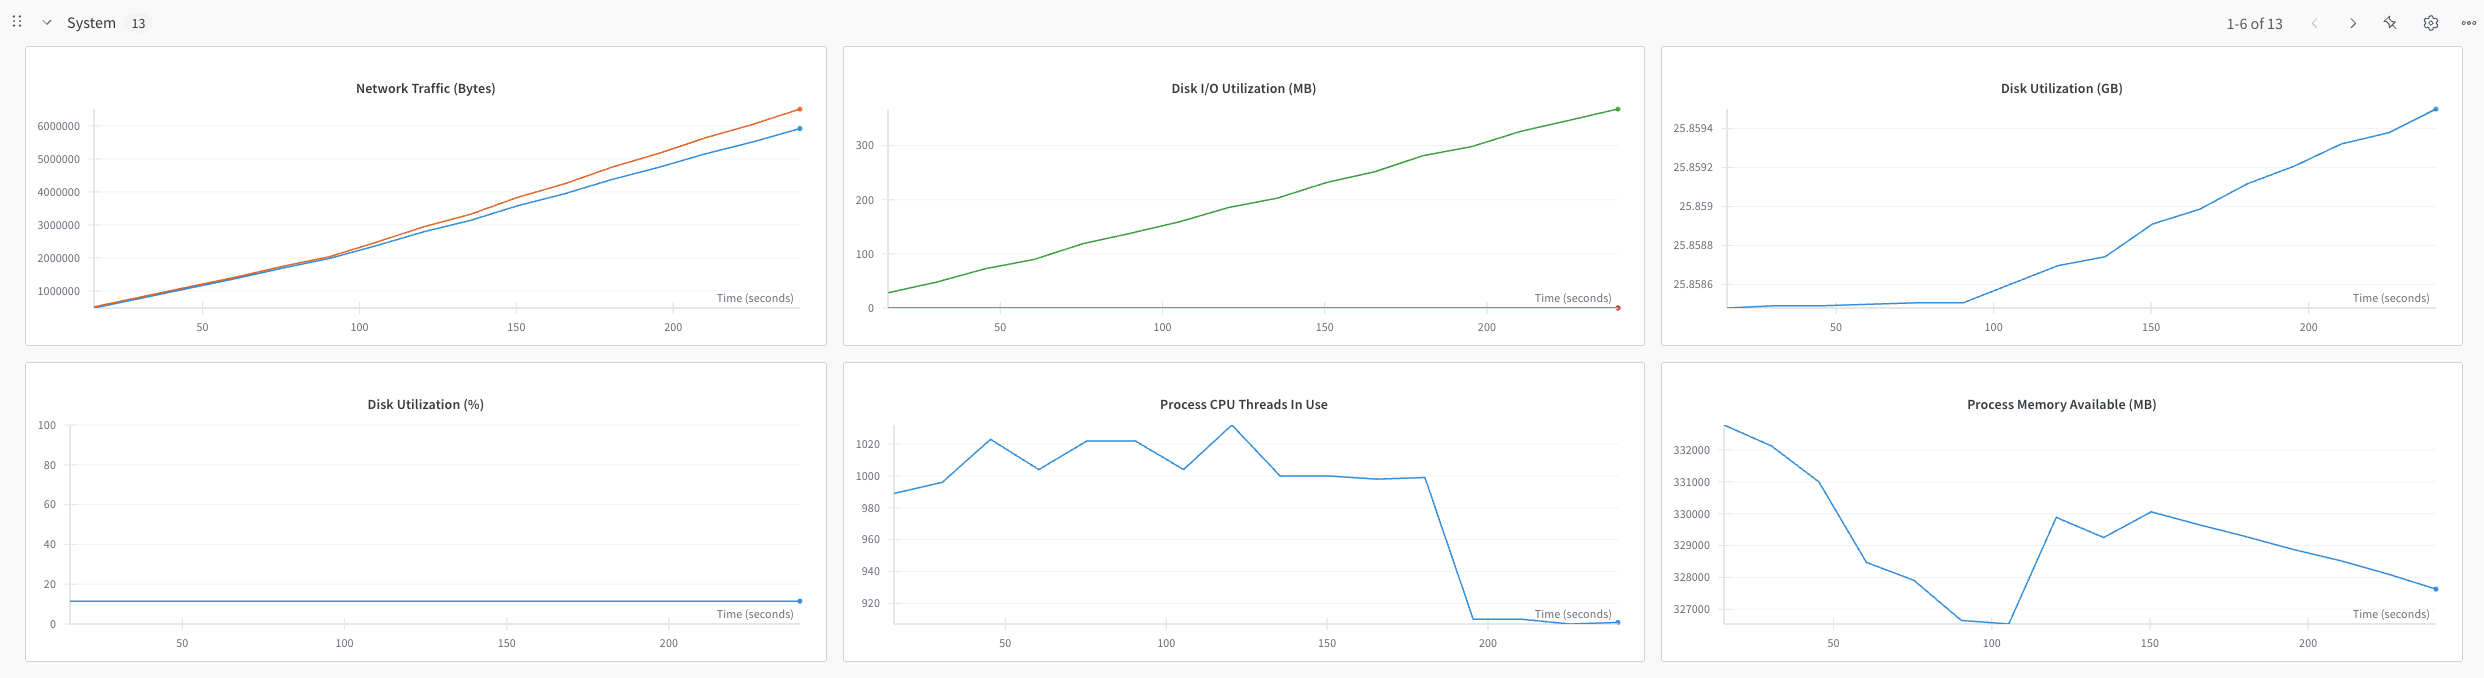

In [3]:
!pip install tensorflow-datasets
!pip install aqtp
!pip install pillow>=11.1.0
!pip install pillow
!pip install omegaconf
!pip install google-cloud-storage

In [4]:
!pip install tensorflow_text transformers tiktoken

## Imports

In [5]:
import gc
import os
import time

from flax import nnx
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from qwix import lora
from tunix.generate import sampler as sampler_lib
from tunix.models.gemma import data as data_lib
from tunix.models.gemma import gemma as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.sft import metrics_logger
from tunix.sft import peft_trainer

## Hyperparameters

In [6]:
# Data
BATCH_SIZE = 16

# Model
MESH = [(1, 8), ("fsdp", "tp")]
# LoRA
RANK = 16
ALPHA = 2.0

# Train
MAX_STEPS = 100
EVAL_EVERY_N_STEPS = 20
NUM_EPOCHS = 3


# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "~/qlora_expt/content/intermediate_ckpt/"
CKPT_DIR = "~/qlora_expt/content/ckpts/"
PROFILING_DIR = "~/qlora_expt/content/profiling/"

## Load Gemma 2B

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
[here](https://www.kaggle.com/models/google/gemma/flax/).

In [7]:
# Log in
# if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
  # kagglehub.login()


In [8]:
kaggle_ckpt_path = kagglehub.model_download("google/gemma/flax/2b")

In [9]:
# # This is a workaround. The checkpoints on Kaggle don't work with NNX. So, we
# # load the model, save the checkpoint locally, and then reload the model
# # (sharded).
# params = params_lib.load_and_format_params(os.path.join(kaggle_ckpt_path, "2b"))
# gemma = gemma_lib.Transformer.from_params(params, version="2b")
# checkpointer = ocp.StandardCheckpointer()
# _, state = nnx.split(gemma)
# checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)

In [10]:
# # # Wait for the ckpt to save successfully.
# time.sleep(60)

In [11]:
# # Delete the intermediate model to save memory.
# del params
# del gemma
# del state
# gc.collect()

In [12]:
import sys
import os

# add the parent directory (one level up) to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../maxtext')))

# ! pip install -r ../../maxtext/requirements.txt

import MaxText as mt
from MaxText import pyconfig

2025-08-01 00:51:51.741452: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754009511.753733 1763708 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754009511.757369 1763708 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754009511.767635 1763708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754009511.767647 1763708 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754009511.767648 1763708 computation_placer.cc:177] computation placer alr

In [ ]:
from MaxText.integration.tunix.tunix_adaptor import TunixMaxTextLlama
from flax import linen as nn

def get_ref_maxtext_model():

  #python3 -m MaxText.train MaxText/configs/base.yml base_output_directory=${BASE_OUTPUT_DIRECTORY} dataset_path=${DATASET_PATH} tokenizer_path=assets/tokenizer.gemma load_parameters_path=${CONVERTED_CHECKPOINT} per_device_batch_size=1 run_name=${FINETUNE_RUN_NAME} max_target_length=8192 steps=10 async_checkpointing=false model_name=gemma-2b checkpoint_period=5

  #TODO: @mazumdera: change this to use Gemma2-2b-it
  config = pyconfig.initialize(
      ["", "../../maxtext/MaxText/configs/base.yml"], #TODO: @mazumdera: why decode.py?
      base_output_directory="gs://dummy_output_dir",  # This is not used in Tunix.
      run_name="test-tunix-maxtext-llama3-8b",
      # dataset_path=we use Tunix's dataset
      # load_parameters_path="gs://maxtext-gemma/2b/", #TODO: @mazumdera: change this to use checkpoint
      # tokenizer_type="tiktoken",
      # tokenizer_path="assets/tokenizer_llama3.tiktoken",
      tokenizer_path="../../maxtext/assets/tokenizer.gemma",
      per_device_batch_size=1,
      max_target_length=8192,
      steps=10,
      async_checkpointing="false",
      # model_name="llama3.1-8b",
      model_name="gemma-2b"
      checkpoint_period=5,
      skip_jax_distributed_system="true",
      weight_dtype="bfloat16",
  )
  
  # checkpoint = mt.checkpointing.load_params_from_path(
  #     load_parameters_from_path="gs://maxtext-gemma/2b/",
  #     abstract_unboxed_params=None,
  #     checkpoint_storage_concurrent_gb=None,
  # )
  checkpoint = {}

  def create_model(config):
    return mt.from_pretrained(config, rngs=nnx.Rngs(params=0, dropout=1))

  model = nnx.eval_shape(create_model, config=config)

  @nnx.jit
  def partial_init(checkpoint, config):
    model = create_model(config)
    nnx.update(model, checkpoint)
    # shard model
    state = nnx.state(model)
    specs = nnx.get_partition_spec(state)
    state = jax.lax.with_sharding_constraint(state, specs)
    nnx.update(model, state)
    return model

  with jax.sharding.use_mesh(model.mesh), nn.logical_axis_rules(config.logical_axis_rules):
    model = partial_init(checkpoint, config)
  print(model)

  
  tunix_model = TunixMaxTextLlama(
        base_model=model,
        use_attention_mask=False,  # trust Tunix loss masking
    )
  mesh  = tunix_model.base.mesh
  
  #TODO: @mazumdera: change this to use llama3.1-8b
  model_config = None
  # # We can continue to use Tunix's model_config
  # model_config = gemma_lib.TransformerConfig.gemma2_2b()

  # Add these lines to properly get the graph definition and state
  graphdef, state = nnx.split(tunix_model)
  tunix_model = nnx.merge(graphdef, state)  # Recreate model in proper NNX format
    
  
  return tunix_model, mesh, model_config

In [18]:
# Base model
# gemma, mesh, model_config = get_base_model(
#     ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state")
# )

gemma, mesh, model_config = get_ref_maxtext_model()
# gemma_maxtext_nnx = nnx.bridge.ToNNX(gemma)
# Instead of:
nnx.display(gemma)

# Use:
print("Model initialized successfully")
print(f"Model mesh shape: {mesh.shape}")
print(f"Model config: {model_config}")

Updating keys from env and command line: ['run_name', 'model_name', 'async_checkpointing', 'checkpoint_period', 'weight_dtype', 'base_output_directory', 'tokenizer_path', 'tokenizer_type', 'per_device_batch_size', 'steps', 'skip_jax_distributed_system', 'max_target_length']
Running Model: llama3-8b
Updating following parameters in config

base_emb_dim: 4096
base_num_query_heads: 32
base_num_kv_heads: 8
base_num_decoder_layers: 32
base_mlp_dim: 14336
head_dim: 128
mlp_activations: ['silu', 'linear']
vocab_size: 128256
enable_dropout: False
logits_via_embedding: False
normalization_layer_epsilon: 1e-05
rope_max_timescale: 500000
decoder_block: llama2
Updating keys from model: ['base_emb_dim', 'base_num_query_heads', 'base_num_kv_heads', 'base_num_decoder_layers', 'base_mlp_dim', 'head_dim', 'mlp_activations', 'vocab_size', 'enable_dropout', 'logits_via_embedding', 'normalization_layer_epsilon', 'rope_max_timescale', 'decoder_block']
Skipping jax distributed system due to skip_jax_distrib

Config param enable_data_shuffling: True
Config param enable_dropout: False
Config param enable_emergency_checkpoint: False
Config param enable_gcp_goodput_metrics: True
Config param enable_gcp_step_deviation_metrics: True
Config param enable_goodput_recording: False
Config param enable_jax_profiler: False
Config param enable_llm_inference_pool: False
Config param enable_model_warmup: False
Config param enable_orbax_v1: False
Config param enable_padding_causal_mask: True
Config param enable_pathways_goodput: False
Config param enable_prefix_caching: False
Config param enable_single_controller: False
Config param enable_single_replica_ckpt_restoring: False
Config param enable_tensorboard: True
Config param eval_data_columns: ['text']
Config param eval_dataset_name: c4/en:3.0.1
Config param eval_image_column: image
Config param eval_interval: -1
Config param eval_per_device_batch_size: 1.0
Config param eval_split: validation
Config param eval_steps: -1
Config param expansion_factor_real_

/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/renderers.py:251: UserWarning: Ignoring error inside wrapper hook <function replace_with_canonical_aliases at 0x792e0abf4540>:
Traceback (most recent call last):
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/renderers.py", line 225, in _render_subtree
    postprocessed_result = hook(
                           ^^^^^
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/_internal/handlers/canonical_alias_postprocessor.py", line 78, in replace_with_canonical_aliases
    maybe_alias = canonical_aliases.lookup_alias(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mazumdera_google_com/venv-py311/lib/python3.11/site-packages/treescope/canonical_aliases.py", line 317, in lookup_alias
    unwrapped = inspect.unwrap(the_object)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/inspect.py", line 756, in unwrap
   

Model initialized successfully
Model mesh shape: OrderedDict([('data', 1), ('stage', 1), ('fsdp', 1), ('fsdp_transpose', 1), ('sequence', 1), ('context', 1), ('context_autoregressive', 1), ('tensor', 1), ('tensor_transpose', 1), ('tensor_sequence', 1), ('expert', 1), ('autoregressive', 1)])
Model config: None


In [ ]:
# def get_base_model(ckpt_path):

#   model_config = gemma_lib.TransformerConfig.gemma_2b()
#   mesh = jax.make_mesh(*MESH)
#   abs_gemma: nnx.Module = nnx.eval_shape(
#       lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
#   )
#   abs_state = nnx.state(abs_gemma)
#   abs_state = jax.tree.map(
#       lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
#       abs_state,
#       nnx.get_named_sharding(abs_state, mesh),
#   )
#   checkpointer = ocp.StandardCheckpointer()
#   restored_params = checkpointer.restore(ckpt_path, target=abs_state)

#   graph_def, _ = nnx.split(abs_gemma)
#   gemma = nnx.merge(graph_def, restored_params)
#   return gemma, mesh, model_config

## Prompt the model

Let's see how the model performs on the English-French translation task.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

from MaxText.input_pipeline import _input_pipeline_utils
from MaxText.globals import PKG_DIR

# gemma_tokenizer = _input_pipeline_utils.get_tokenizer(
#         os.path.join(os.path.dirname(PKG_DIR), "assets", "tokenizer_llama3.tiktoken"),
#         "tiktoken",
#         add_bos=True,
#         add_eos=False,
#     )
#     )
# gemma_tokenizer = data_lib.GemmaTokenizer(
# )

sampler = sampler_lib.Sampler(
    transformer=gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")

----------------------
Prompt:
Translate this into French:
Hello, my name is Morgane.

Output:
 life HEn se<unused82>                    Lле it</blockquote>
----------------------
Prompt:
Translate this into French:
This dish is delicious!

Output:
 life HEn se<unused82>                    Lле it</blockquote>
----------------------
Prompt:
Translate this into French:
I am a student.

Output:
 life HEn se<unused82>                    Lле it</blockquote>
----------------------
Prompt:
Translate this into French:
How's the weather today?

Output:
 life HEn se<unused82>                    Lле it</blockquote>


## Apply LoRA/QLoRA to the model

In [ ]:
def get_lora_model(base_model, mesh):
  lora_provider = lora.LoraProvider(
      module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
      rank=RANK,
      alpha=ALPHA,
      # comment the two args below for LoRA (w/o quantisation).
      weight_qtype="nf4",
      tile_size=256,
  )

  model_input = base_model.get_model_input()
  lora_model = lora.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [ ]:
# # LoRA model
# lora_gemma = get_lora_model(gemma, mesh=mesh)
# nnx.display(lora_gemma)

## Load Datasets for SFT Training

In [ ]:
# Loads the training and validation datasets
train_ds, validation_ds = data_lib.create_datasets(
    dataset_name='mtnt/en-fr',
    # Uncomment the line below to use a Hugging Face dataset.
    # Note that this requires upgrading the 'datasets' package and restarting
    # the Colab runtime.
    # dataset_name='Helsinki-NLP/opus-100',
    global_batch_size=BATCH_SIZE,
    max_target_length=256,
    num_train_epochs=NUM_EPOCHS,
    tokenizer=gemma_tokenizer,
)


def gen_model_input_fn(x: peft_trainer.TrainingInput):
  pad_mask = x.input_tokens != gemma_tokenizer.pad_id()
  positions = gemma_lib.build_positions_from_mask(pad_mask)
  attention_mask = gemma_lib.make_causal_attn_mask(pad_mask)
  return {
      'input_tokens': x.input_tokens,
      'input_mask': x.input_mask,
      'positions': positions,
      'attention_mask': attention_mask,
  }

## SFT Training

### Training with full weights

In [ ]:
logging_option = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/tensorboard/full", flush_every_n_steps=20
)
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    metrics_logging_options=logging_option,
)
trainer = peft_trainer.PeftTrainer(gemma, optax.adamw(1e-5), training_config)
trainer = trainer.with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "full_training")):
  with mesh:
    trainer.train(train_ds, validation_ds)

wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


### Training with LoRA/QLoRA

In [ ]:
# Restart Colab runtime.

training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
lora_trainer = peft_trainer.PeftTrainer(
    lora_gemma, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft")):
  with mesh:
    lora_trainer.train(train_ds, validation_ds)

### Compare profile results of different training

<font size=3>Setup<font>           | <font size=3>Train Step Time<font> | <font size=3>Peak Memory Usage<font>
---------------------------------- | ---------------------------------- | ------------------------------
<font size=3>Full weights<font>        |   <font size=3>~1.22 s<font>     |   <font size=3>43.26 GiB<font>
<font size=3>QLoRA<font>        |   <font size=3>~1.19 s<font>     |   <font size=3>28.14 GiB<font>

## Generate with the LoRA/QLoRA model

The QLoRA model still cannot do English-to-French translation properly since we
only trained for 100 steps. If you train it for longer, you will see better
results.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

sampler = sampler_lib.Sampler(
    transformer=lora_gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")